# DeepCodec on MNIST

Here we jointly optimizing the sensing matrix $A$ as well as the reconstruction layer. Hopefully, this will get us much better results than before. Also, it makes loading the test and training batches so much easier!

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from torch import distributions as ds
from torch.utils import data as utils

import numpy as np
import scipy
import sys
from matplotlib import pyplot as plt
%matplotlib inline

# Liveloss plot plots loss just for jupyter notebooks
from livelossplot import PlotLosses

In [3]:
BATCH_SIZE = 4096
ORIGINAL_SIZE = 28
UNDERSAMPLED_SIZE = 15
N = ORIGINAL_SIZE * ORIGINAL_SIZE
M = UNDERSAMPLED_SIZE * UNDERSAMPLED_SIZE

In [4]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
batch_size=BATCH_SIZE, shuffle=True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device: %s' % str(device))

Using device: cuda:0


In [6]:
class WFUMNISTCodec(nn.Module):
    """A NN that definitely won't work, lmao, Test our dataloader."""
    def __init__(self, original_res, sensing_res):
        """Makes a FCN type architecture, takes in picture dimension d x d"""
        super(WFUMNISTCodec, self).__init__()
        
        self.m = sensing_res
        # Sensing matrix
        self.sensing = torch.nn.Linear(original_res * original_res, sensing_res * sensing_res, bias=False)
        
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 8, kernel_size=4, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1)
        self.upsample = torch.nn.UpsamplingBilinear2d(size=(original_res, original_res))
        
        
        
    def forward(self, x):
        # Apply the sensing matrix without activation, reshape back to image-like for FCN
        x = self.sensing(x.view(x.shape[0], -1)).view(x.shape[0], 1, self.m, self.m)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return self.upsample(x)

In [23]:
class WFUMNISTCodecLarge(nn.Module):
    """A NN that definitely won't work, lmao, Test our dataloader."""
    def __init__(self, original_res, sensing_res):
        """Makes a FCN type architecture, takes in picture dimension d x d"""
        super(WFUMNISTCodec, self).__init__()
        
        self.m = sensing_res
        # Sensing matrix
        self.sensing = torch.nn.Linear(original_res * original_res, sensing_res * sensing_res, bias=False)
        
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 16, kernel_size=4, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(16, 4, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1)
        self.upsample = torch.nn.UpsamplingBilinear2d(size=(original_res, original_res))
        
        
        
    def forward(self, x):
        # Apply the sensing matrix without activation, reshape back to image-like for FCN
        x = self.sensing(x.view(x.shape[0], -1)).view(x.shape[0], 1, self.m, self.m)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return self.upsample(x)

In [8]:
# Early Stopping Policy:
# If we plateau for more than N steps, TERMINATE
test_losses = []
TERM_EPOCHS = 100000000
LR_DECAY_STEPS = 10

def train_fcn_mnist(network, epochs=1000, lr=0.001):
    import tqdm
    liveloss = PlotLosses()
    # epoch_queue = tqdm.tqdm(range(epochs))
    for epoch in range(epochs):
        training_loss = 0
        for index, batch in enumerate(train_loader):
            X, _ = batch
            y = X.clone().to(device)
            X = X.to(device)
            
            optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.5)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
            criterion = nn.MSELoss()

            optimizer.zero_grad()
            y_hat = network(X)
            loss = criterion(y_hat, y.to(device))
            loss.backward()
            optimizer.step()
            
            training_loss += float(loss.detach().cpu())
            
            lr_string = ""
            for param_group in optimizer.param_groups:
                lr_string = str(param_group['lr'])
            # epoch_queue.set_description("Loss this batch: %s and %s" % (str(loss / 16 / 32 / 32 / 3 ), lr_string))
            
        test_loss = 0
        for index, batch in enumerate(test_loader):
            X_test, _ = batch
            y_test = X_test.clone().to(device)
            X_test = X_test.to(device)
            y_hat = network(X_test.to(device))
            test_loss += float(criterion(y_hat, y_test))
        test_losses.append(test_loss)
        # Terinate if we don't get past the min in TERM_EPOCH steps
        # and its over the average
        if epoch - np.array(test_losses).argmin() > TERM_EPOCHS and (test_losses[-1] > np.array(test_losses)[-TERM_EPOCHS:].mean()):
            print('Terminated due to plateu')
            return
        
        liveloss.update({
            'train': training_loss,
            'accuracy': test_loss
        })
        liveloss.draw()
        
        
        if (epoch + 1) % LR_DECAY_STEPS == 0:
            scheduler.step()

In [25]:
wfunet = WFUMNISTCodec(ORIGINAL_SIZE, UNDERSAMPLED_SIZE).to(device)

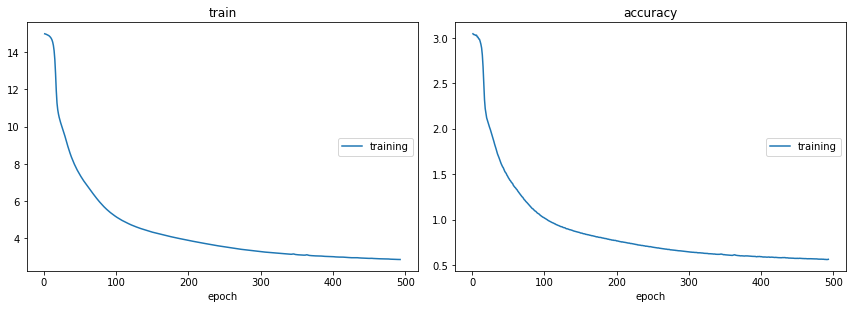

train:
training   (min:    2.860, max:   14.984, cur:    2.861)

accuracy:
training   (min:    0.559, max:    3.046, cur:    0.561)


KeyboardInterrupt: 

In [26]:
train_fcn_mnist(wfunet, lr=0.01)

In [27]:
random_test_X, random_test_y = None, None
for X, y in train_loader:
    random_test_X = X.clone()
    random_test_y = X.clone()
    break

# random_test_X, random_test_y = None, None
# for X, y in test_loader:
#     random_test_X = X.clone()
#     random_test_y = X.clone()
#     break

In [28]:
test_y_hat = wfunet(random_test_X.to(device)).detach()
result_images = test_y_hat.permute(0, 3, 1, 2).cpu().numpy().reshape(test_y_hat.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE).swapaxes(1, 2)
actual = random_test_y.permute(0, 3, 1, 2).cpu().numpy().reshape(random_test_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE).swapaxes(1, 2)

In [29]:
indexes = [13, 14, 15, 16]

def plot_examples(index_lst):
    SIZE = 12
    plt.figure(figsize=(SIZE, len(index_lst)/2 * SIZE))  
    for i, index in enumerate(index_lst):
        # Get minimum of the result and the real image to use same colorbar colors
        min_val = min(result_images[index].min(), actual[index].min())
        max_val = max(result_images[index].max(), actual[index].max())
        plt.subplot(len(index_lst), 2, 2*i + 1)
        res = (((result_images[index] + 0.1307)))
        plt.imshow(res, cmap='gray', vmin=min_val, vmax=max_val)
        plt.colorbar()
        plt.autoscale(False)
        
        plt.subplot(len(index_lst), 2, 2*i + 2)
        a = ((actual[index] + 0.1307))
        plt.imshow(a, cmap='gray', vmin=min_val, vmax=max_val)
        plt.colorbar()
        plt.autoscale(False)
        
    plt.show()

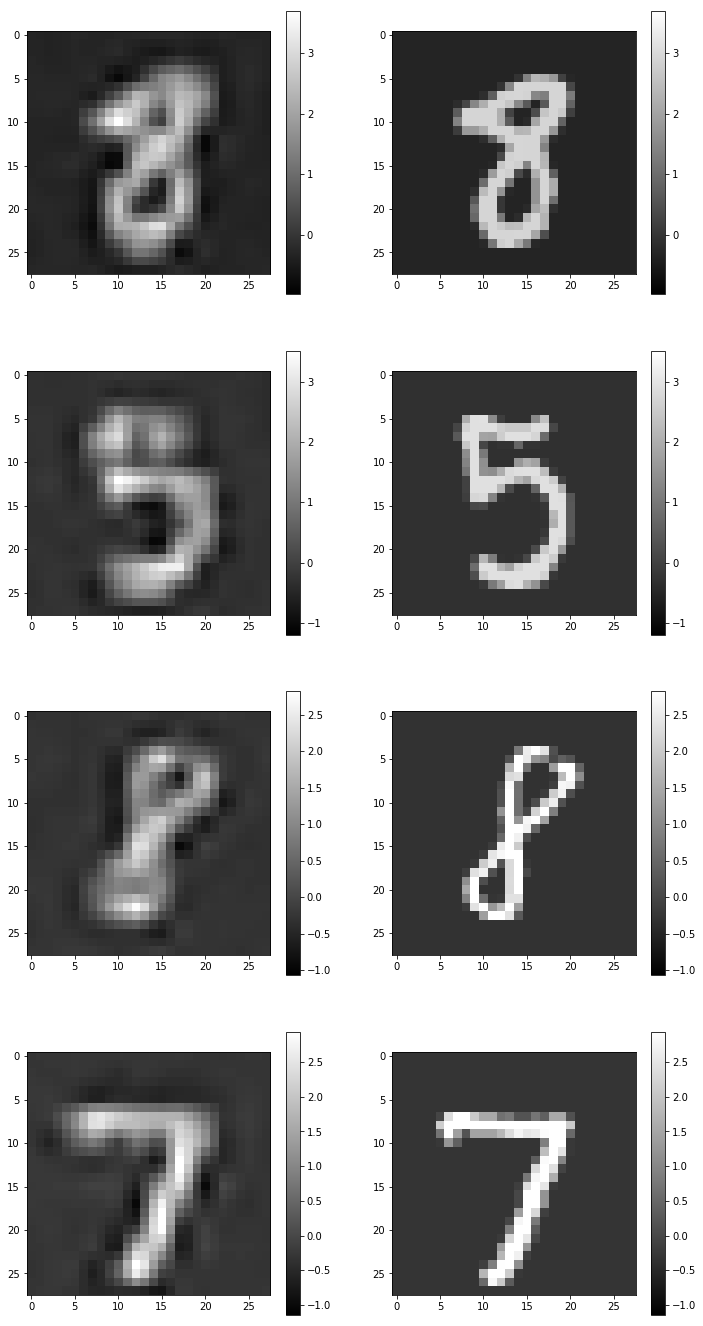

In [30]:
plot_examples([17, 18, 19, 20, 21, ])

## Scanning Undersampling

Now we want to get some joinly learned sensing matrices for different undersampling ratios. Let's do this!

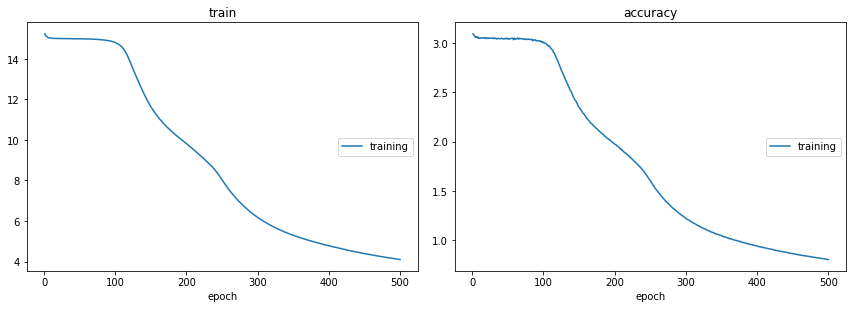

train:
training   (min:    4.101, max:   15.234, cur:    4.101)

accuracy:
training   (min:    0.807, max:    3.091, cur:    0.807)


In [10]:
undersample_sizes = [9, 10, 11, 13, 14, 15]
for under in undersample_sizes:
    print(under)
    smallnet = WFUMNISTCodec(ORIGINAL_SIZE, under).to(device)
    train_fcn_mnist(smallnet, lr=0.005, epochs=500)
    torch.save(smallnet, 'wfunetsmall_conv_28_to_{}.torchmodel'.format(under))

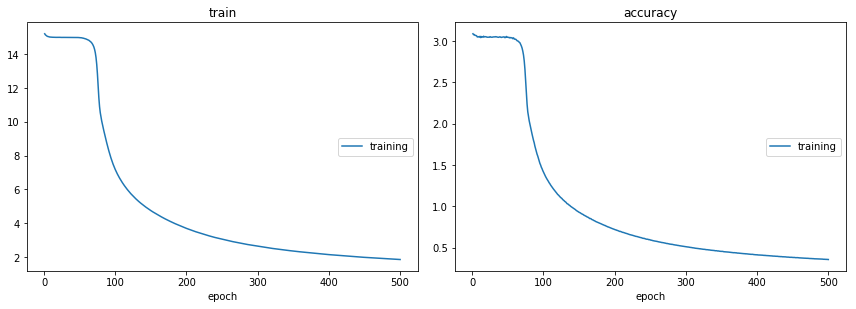

train:
training   (min:    1.839, max:   15.214, cur:    1.839)

accuracy:
training   (min:    0.358, max:    3.086, cur:    0.358)


In [11]:
undersample_sizes = [17, 18, 19, 21, 22, 23, 25, 26, 27]
for under in undersample_sizes:
    print(under)
    smallnet = WFUMNISTCodec(ORIGINAL_SIZE, under).to(device)
    train_fcn_mnist(smallnet, lr=0.005, epochs=500)
    torch.save(smallnet, 'wfunetsmall_conv_28_to_{}.torchmodel'.format(under))